In [ ]:
import numpy as np
from numba import cuda
import numba as nb
from time import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def to_byte_array(text):
  return np.array([int(x) for x in text.encode('utf-8')], dtype=np.uint64)

def from_byte_array(b):
  return b.tobytes().decode('utf-8')

@cuda.jit
def search_gpu(text, words, matrix):
  i = cuda.grid(1)
  for j in range(text.size):
    idx = 0
    while words[i][idx]!=0:
      if text[idx+j] != words[i][idx]:
        matrix[i][j] = 0
        break
      matrix[i][j] = 1    
      idx+=1    

def search_cpu(text, words):
  matrix = np.zeros((int(words.size/100), text.size), dtype=np.bool)
  start=time()
  for i in range(matrix.shape[0]):
    for j in range(text.size):
      idx=0
      while words[i][idx]!=0 and j+idx<text.size:
        if text[idx+j] != words[i][idx]:
          matrix[i][j]=0
          break
        matrix[i][j]=1
        idx+=1
  return matrix, time()-start

def execution_search_gpu(text, words, block):
  matrix = np.zeros((int(words.size/100), text.size), dtype=np.bool)

  words_global = cuda.to_device(words)
  text_global = cuda.to_device(text)
  matrix_global = cuda.to_device(matrix)

  grid = int((len(words) + block - 1)/block)
  start = time()
  search_gpu[grid, block](text_global, words_global, matrix_global)
  l=matrix_global.copy_to_host()
  return l, time()-start

def get_param(text, words):
  text_byte = to_byte_array(text)
  words_bytes = np.array([to_byte_array(word) for word in words])
  words_byte = np.zeros((words_bytes.size, 100), dtype=np.uint8)
  for i in range(len(words)):
    for j in range(words_bytes[i].size):
      words_byte[i][j] = words_bytes[i][j]
  return text_byte, words_byte

def result_interpretator(words, matrix):
  indexes=[]
  for i in range(len(words)):
    t=[]
    for j in range(matrix[i].size):
      if matrix[i][j]==True:
        t.append(j)
    indexes.append(t)
  
  for i in range(len(words)):
    print('для слова: \'', words[i] ,'\'\t вхождений: ', len(indexes[i]),'\t',indexes[i][:5], indexes[i][-5:])

def experiment(words, k, block):
  if 2**k <= len(words):
    words = words[:2**k]
  else:
    while 2**k > len(words):
      words = words + words 
  text_byte, words_byte = get_param(text, words)
  result_cpu, time_cpu = search_cpu(text_byte, words_byte)
  result_gpu, time_gpu = execution_search_gpu(text_byte, words_byte, block)
  return time_cpu, time_gpu, len(words)

n=50000
text =  open('text.txt', 'r').read(n)
words = [] 
words.append(text[1:4])
words.append(text[-2:])
words = words + [ 'you', 'to', 'me', 'and', 'stop', 'of', 'end', 'for', 'the', 'my', 'some', 'any', 'at', 'they',
                 'up', 'down', 'with', 'all', 'other', 'in', 'on', 'over', 'from', 'then', 
                 'if', 'very', 'who', 'what', 'when', 'how', 'get', 'can', 'do', 'be', '.', ' ',
                 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

**График зависимости ускорения от количества слов для поиска:**

log: 1 completed 	 0.27062463760375977 	 0.023103952407836914 	 11.713348124451782 	 2 	 0.30796217918395996
log: 2 completed 	 0.5369057655334473 	 0.022540807723999023 	 23.819278000486552 	 4 	 0.5706954002380371
log: 3 completed 	 1.077223300933838 	 0.02277994155883789 	 47.2882381261382 	 8 	 1.110750675201416
log: 4 completed 	 2.2157015800476074 	 0.023154020309448242 	 95.69403284765484 	 16 	 2.2496047019958496
log: 5 completed 	 4.282284736633301 	 0.02353978157043457 	 181.9169274710583 	 32 	 4.3172900676727295
log: 6 completed 	 8.774871110916138 	 0.023798704147338867 	 368.7121389715385 	 64 	 8.813358306884766
log: 7 completed 	 17.186328887939453 	 0.024629831314086914 	 697.7850830066309 	 128 	 17.22555661201477
log: 8 completed 	 34.75769639015198 	 0.026238441467285156 	 1324.6860120670228 	 256 	 34.802096128463745
log: 9 completed 	 69.5259473323822 	 0.030025959014892578 	 2315.5279502612398 	 512 	 69.58777976036072
log: 10 completed 	 138.75109672546387 	 0.0

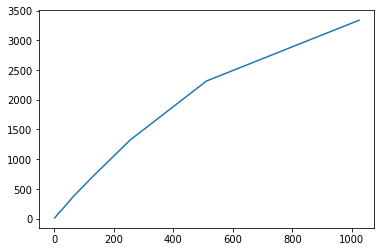

In [ ]:
a = []
ns = []

k=10
for i in range(1, k+1):
  start=time()
  c, g, n = experiment(words, i, 4)
  a.append(c/g)
  ns.append(n)
  print('log:', i, 'completed','\t', c, '\t', g, '\t', c/g, '\t', n, '\t', time()-start)

plt.plot(ns, a)
plt.show()

**Один подробный эксперимент:**

In [16]:
text_byte, words_byte = get_param(text, words)
result_cpu, time_cpu = search_cpu(text_byte, words_byte)
result_gpu, time_gpu = execution_search_gpu(text_byte, words_byte, 4)

print('эксперимент для', len(words))
print('первые 20 символов: \"', text[0:20], "\"\n")
print('последние 20 символов \"', text[-20:], "\"\n")

print('\n\nслова: ',len(words), words)

print('time_gpu: ', time_gpu)
print('result_gpu: \n', result_gpu)
result_interpretator(words, result_gpu)

print('\n\ntime_cpu: ', time_cpu)
print('result_cpu: \n', result_cpu)
result_interpretator(words, result_cpu)

print('Ускорение: ', time_cpu/time_gpu)

эксперимент для 64
первые 20 символов: " Treasure Island

Rob "

последние 20 символов " our hands on thousan "



слова:  64 ['rea', 'an', 'you', 'to', 'me', 'and', 'stop', 'of', 'end', 'for', 'the', 'my', 'some', 'any', 'at', 'they', 'up', 'down', 'with', 'all', 'other', 'in', 'on', 'over', 'from', 'then', 'if', 'very', 'who', 'what', 'when', 'how', 'get', 'can', 'do', 'be', '.', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
time_gpu:  0.023890018463134766
result_gpu: 
 [[False  True False ... False False False]
 [False False False ... False  True False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
для слова: ' rea '	 вхождений:  55 	 [1, 605, 743, 1410, 4808] [44481, 44559, 44967, 48277, 48716]
для слова: ' an '	 вхождений:  734 	 [12, 133, 143, 162, 514] [49868, 4